## Import libraries

In [3]:
import warnings
# отключаем вывод предупреждений в консоль (чтобы она не засорялась)
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd
# библиотека для визуализации данных
import seaborn as sns 
import matplotlib.pyplot as plt
# библиотека для статистического анализа данных (статистических тестов)
from scipy import stats

# библиотека для градиентного бустинга
from xgboost import XGBClassifier
# библиотека для градиентного бустинга
from lightgbm import LGBMClassifier
# библиотека для градиентного бустинга и работы с категориальными данными
from catboost import CatBoostClassifier
# матрика для измерения качества моделей
from sklearn.metrics import roc_auc_score
# метод make_pipline создает конвейеры (объединяет шаги предобработки (кодирование признаков) и модель в единый процесс)
from sklearn.pipeline import make_pipeline
# кодирование категориальных признаков
from category_encoders import TargetEncoder
# оптимизация гиперпараметров или ансамблей
from hillclimbers import climb_hill, partial
# нейронная сеть - модель для классификации
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
# ансамблевый метод для классификации
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
# оценка калибровки вероятности модели
from sklearn.calibration import CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# инструмент для кросс-валидации
from sklearn.model_selection import StratifiedKFold
# вычисление взаимной информации между признаками и целевой переменной
from sklearn.feature_selection import mutual_info_classif

In [4]:
oof = {}
test_pred = {}
NUM_FOLD = 5
target = 'loan_status'

## Загрузим данные

In [5]:
train = pd.read_csv('data/train.csv', index_col='id')
test = pd.read_csv('data/test.csv', index_col='id')
original = pd.read_csv('data/credit_risk_dataset.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')
train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


## Исследуем данные

In [8]:
original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


In [10]:
# отделим признаки и целевую перменную
X_ = train.copy()
y_ = X_.pop("loan_status")

In [11]:
# кодируем категориальные признаки с текстовым типом данных
for col in X_.select_dtypes("object"):
    X_[col], _ = X_[col].factorize()

In [12]:
X_.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
id,,,,,,,,,,,
0,37,35000,0,0.0,0,0,6000,11.49,0.17,0,14
1,22,56000,1,6.0,1,1,4000,13.35,0.07,0,2
2,29,28800,1,8.0,2,2,6000,8.90,0.21,0,10
3,30,70000,0,14.0,3,0,12000,11.11,0.17,0,5
4,22,60000,0,2.0,1,2,6000,6.92,0.10,0,3


In [ ]:
def cross_validation(model, label):
    
    train_copy, test_copy, original_copy = train.copy(), test.copy(), original.copy()
    
    if label in ['cb', 'et', 'rf', 'knn', 'mlp']:
        cat_cols = test_copy.columns.tolist()
        for df in [train_copy, test_copy, original_copy]:
            for col in cat_cols:  
                df[col] = df[col].astype('str').astype('category')
        
    elif label in ['xgb', 'lgbm', 'dart', 'goss']: 
        cat_cols = list(test_copy.select_dtypes(include=['object']).columns)
        for df in [train_copy, test_copy, original_copy]:
            for col in cat_cols:  
                df[col] = df[col].astype('str').astype('category')
                
    X = train_copy.drop([target], axis=1)
    y = train_copy[target]
    X_original = original_copy.drop([target], axis=1)
    y_original = original_copy[target]
        

    val_scores = []
    test_preds_model = []
    oof_model = np.zeros(len(train),)
    
    skf = StratifiedKFold(n_splits=NUM_FOLD, shuffle=True, random_state=1)

    for Fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        X_train = pd.concat([X_train, X_original], axis=0)
        y_train = pd.concat([y_train, y_original]) 
    
        model.fit(X_train, y_train)
    
        y_pred = model.predict_proba(X_val)[:, 1]
    
        roc_auc_score_ = roc_auc_score(y_val, y_pred)
    
        print(f'Fold {Fold}: roc_auc_score= {roc_auc_score_:.5f}')
    
        val_scores.append(roc_auc_score_)
        
        oof_model[val_index] = y_pred
        
        test_preds_model.append(model.predict_proba(test_copy)[:, 1])
    # сохраняем предсказания конкретной модели (на валидационном наборе(на каждом фолде) - т.е. она будет полностью заполнена)
    oof[label] = oof_model
    # усредняем предсказания на тестовом наборе по всем фолдам
    test_preds_model = sum(test_preds_model)/len(test_preds_model)
    test_pred[label] = test_preds_model 

    print(f'mean validation roc_auc_score = {np.mean(val_scores):.5f}')
    print(f'std validation roc_auc_score = {np.std(val_scores):.5f}')
    
    plt.figure(figsize=(10, 4))
    plt.suptitle(label, y=1.0, fontsize=20)
    ax = plt.subplot(1, 2, 1)
    plt.title('Calibration')
    CalibrationDisplay.from_predictions(y, oof_model, n_bins=10, strategy='quantile', ax=ax)
    plt.subplot(1, 2, 2)
    plt.title('Histogram')
    plt.hist(oof_model, bins=10)
    plt.show()

Fold 0: roc_auc_score= 0.96538
Fold 1: roc_auc_score= 0.96292
Fold 2: roc_auc_score= 0.96582
Fold 3: roc_auc_score= 0.96499
Fold 4: roc_auc_score= 0.96296
mean validation roc_auc_score = 0.96441
std validation roc_auc_score = 0.00123


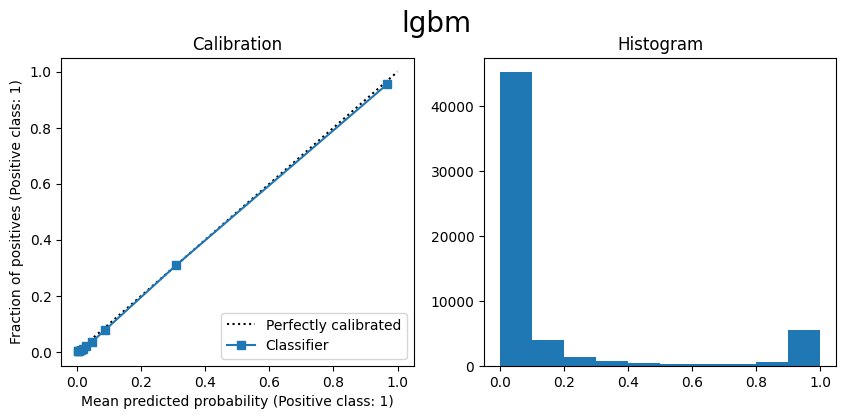

CPU times: total: 9min 47s
Wall time: 2min 44s


In [14]:
%%time

params_lgbm = {
    
    'verbose': -1,
    'random_state': 1,
    'objective': 'binary',
    'n_estimators': 4100,
    'learning_rate': 0.01,
    'colsample_bytree': 0.6,
    'max_depth': 8,
    'max_bin': 5000,
}

model_1 = LGBMClassifier(**params_lgbm)

cross_validation(model_1, 'lgbm')

Fold 0: roc_auc_score= 0.96515
Fold 1: roc_auc_score= 0.96207
Fold 2: roc_auc_score= 0.96602
Fold 3: roc_auc_score= 0.96367
Fold 4: roc_auc_score= 0.96256
mean validation roc_auc_score = 0.96389
std validation roc_auc_score = 0.00150


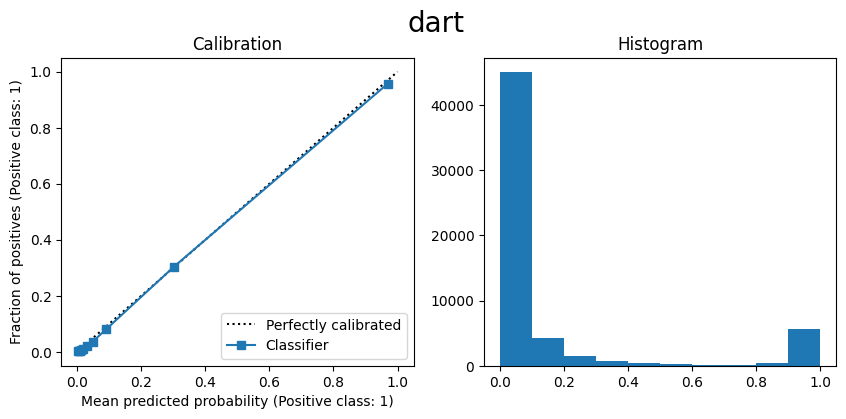

CPU times: total: 16min 37s
Wall time: 4min 26s


In [15]:
%%time

params_dart = {
    
    'verbose': -1,
    'random_state': 1,
    'boosting': 'dart',
    'n_estimators': 600,
    'learning_rate': 0.1,
    'colsample_bytree': 0.6,
    'num_leaves': 85,
    'min_data_in_leaf': 30,
    'max_bin': 1995,
    'objective': 'binary',
}

model_2 = LGBMClassifier(**params_dart)

cross_validation(model_2, 'dart')

Fold 0: roc_auc_score= 0.96598
Fold 1: roc_auc_score= 0.96453
Fold 2: roc_auc_score= 0.96710
Fold 3: roc_auc_score= 0.96601
Fold 4: roc_auc_score= 0.96444
mean validation roc_auc_score = 0.96561
std validation roc_auc_score = 0.00100


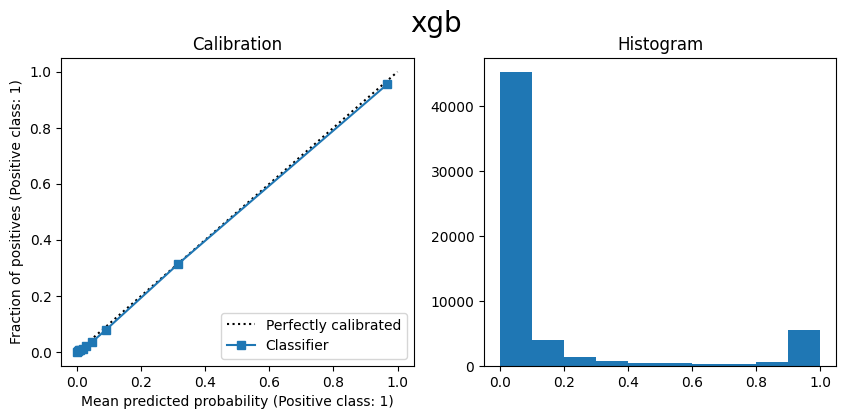

CPU times: total: 30min 36s
Wall time: 4min 34s


In [16]:
%%time

params_xgb = {
    
    'enable_categorical': True,
    'random_state': 1,
    'n_estimators': 10000,
    'learning_rate': 0.01,
    'colsample_bytree': 0.6,
    'reg_lambda': 0.01,
    'max_depth': 4,
    'max_bin': 5000,
    'subsample': 0.95,
    'reg_alpha': 0.1,
 
}

model_3 = XGBClassifier(**params_xgb)

cross_validation(model_3, 'xgb')

Fold 0: roc_auc_score= 0.96536
Fold 1: roc_auc_score= 0.96393
Fold 2: roc_auc_score= 0.96452
Fold 3: roc_auc_score= 0.96477
Fold 4: roc_auc_score= 0.96365
mean validation roc_auc_score = 0.96445
std validation roc_auc_score = 0.00061


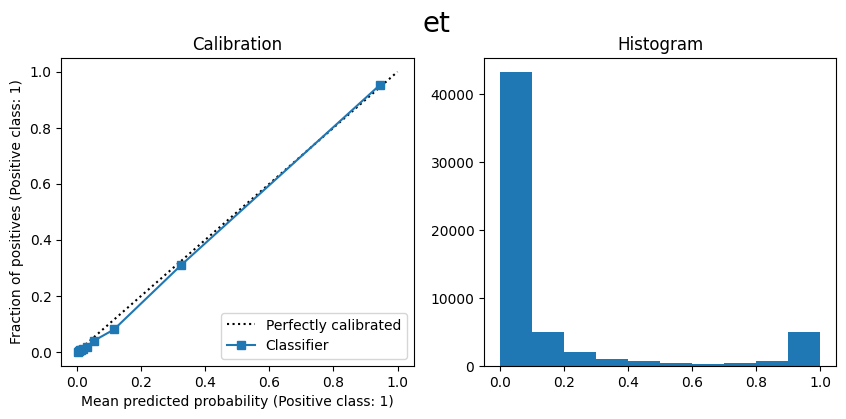

CPU times: total: 5min 52s
Wall time: 6min 3s


In [17]:
%%time

params_et = {
    
    'random_state': 1,
    'n_estimators': 470,
    'min_samples_leaf': 1,
    'max_depth': 20,
    'criterion': 'log_loss',
}

model_4 = make_pipeline(TargetEncoder(), ExtraTreesClassifier(**params_et))

cross_validation(model_4, 'et')

Fold 0: roc_auc_score= 0.96508
Fold 1: roc_auc_score= 0.96277
Fold 2: roc_auc_score= 0.96361
Fold 3: roc_auc_score= 0.96442
Fold 4: roc_auc_score= 0.96212
mean validation roc_auc_score = 0.96360
std validation roc_auc_score = 0.00107


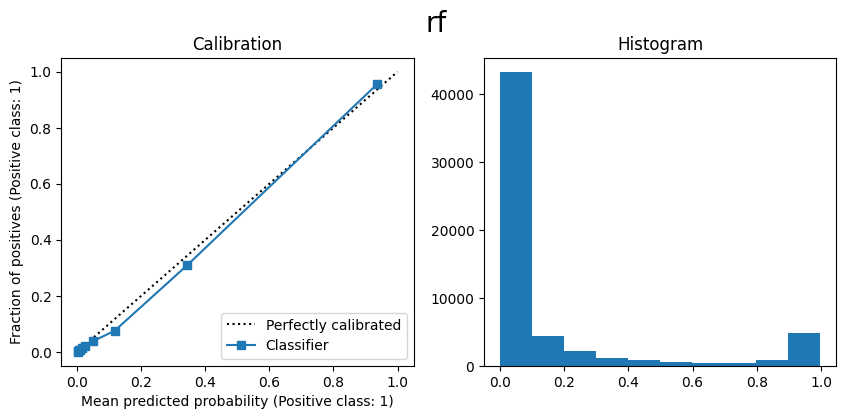

CPU times: total: 7min 12s
Wall time: 7min 24s


In [18]:
%%time

params_rf = {
    
    'random_state': 1,
    'n_estimators': 450,
    'min_samples_leaf': 5,
    'max_leaf_nodes': 960,
    'criterion': 'entropy',
}

model_5 = make_pipeline(TargetEncoder(), RandomForestClassifier(**params_rf))

cross_validation(model_5, 'rf')

Fold 0: roc_auc_score= 0.96988
Fold 1: roc_auc_score= 0.96665
Fold 2: roc_auc_score= 0.96894
Fold 3: roc_auc_score= 0.96998
Fold 4: roc_auc_score= 0.96716
mean validation roc_auc_score = 0.96852
std validation roc_auc_score = 0.00138


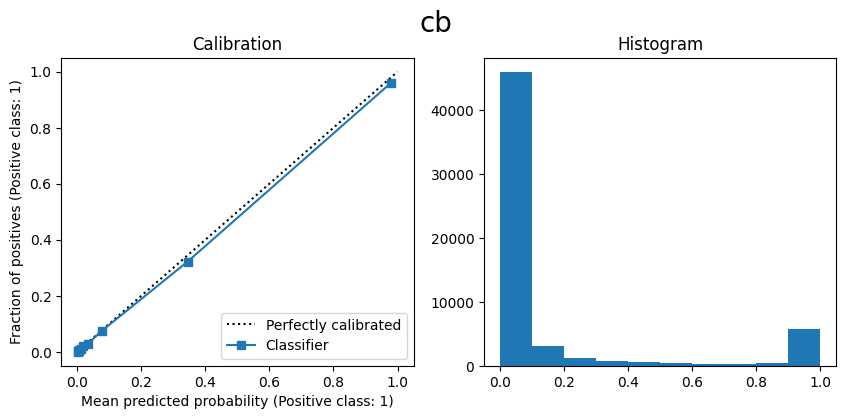

CPU times: total: 2h 57min 5s
Wall time: 32min 55s


In [19]:
%%time

params_cb = {
    
    'verbose': False,
    'random_state': 1,
    'task_type': 'CPU',
    'cat_features' : test.columns.tolist(),
    'min_data_in_leaf': 5,
    'n_estimators': 1800,
    'random_strength': 0.79,
    'depth': 8,
    'bagging_temperature': 0.6,
    'l2_leaf_reg': 4,
    'rsm': 0.6,
}

model_6 = CatBoostClassifier(**params_cb)

cross_validation(model_6, 'cb')

Fold 0: roc_auc_score= 0.95854
Fold 1: roc_auc_score= 0.95563
Fold 2: roc_auc_score= 0.95864
Fold 3: roc_auc_score= 0.95684
Fold 4: roc_auc_score= 0.95586
mean validation roc_auc_score = 0.95710
std validation roc_auc_score = 0.00128


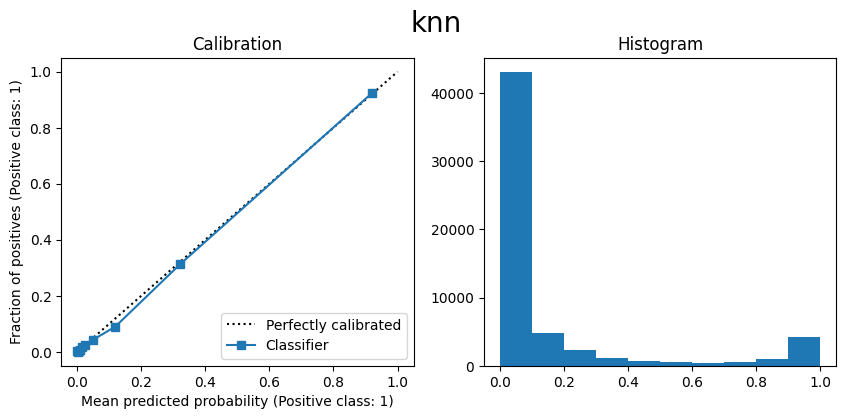

CPU times: total: 4min 25s
Wall time: 4min 27s


In [20]:
%%time

model_7 = make_pipeline(TargetEncoder(), KNeighborsClassifier(n_neighbors=185, 
                                                              metric='manhattan',
                                                              weights='distance'))

cross_validation(model_7, 'knn')

Fold 0: roc_auc_score= 0.96200
Fold 1: roc_auc_score= 0.95869
Fold 2: roc_auc_score= 0.96128
Fold 3: roc_auc_score= 0.96212
Fold 4: roc_auc_score= 0.95948
mean validation roc_auc_score = 0.96072
std validation roc_auc_score = 0.00138


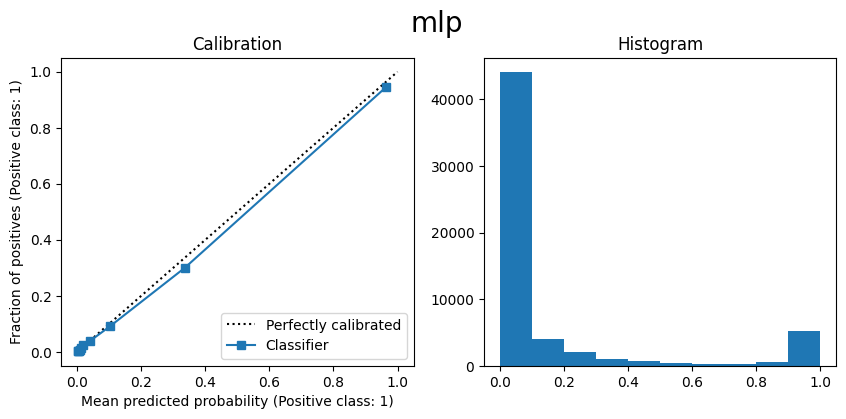

CPU times: total: 2min 22s
Wall time: 2min 23s


In [21]:
%%time

params_mlp = {
    
    'random_state': 1,
    'hidden_layer_sizes': (32, 3),
    
}

model_8 = make_pipeline(TargetEncoder(), StandardScaler(), MLPClassifier(**params_mlp))

cross_validation(model_8, 'mlp')

Fold 0: roc_auc_score= 0.96549
Fold 1: roc_auc_score= 0.96344
Fold 2: roc_auc_score= 0.96587
Fold 3: roc_auc_score= 0.96525
Fold 4: roc_auc_score= 0.96297
mean validation roc_auc_score = 0.96460
std validation roc_auc_score = 0.00117


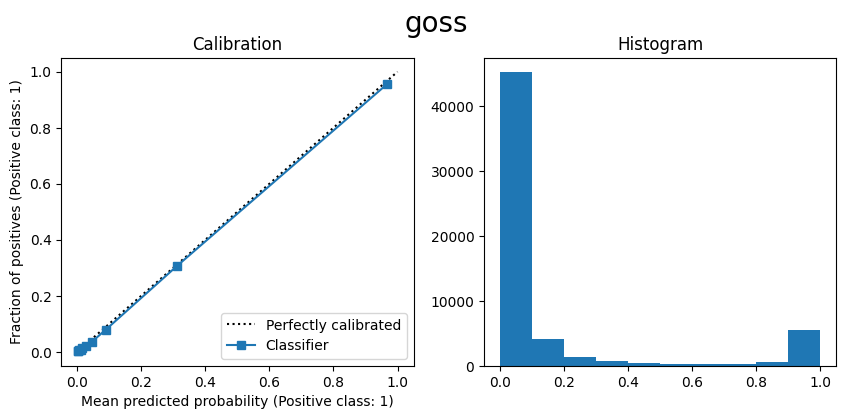

CPU times: total: 9min 56s
Wall time: 2min 41s


In [22]:
%%time

params_goss = {
    
    'verbose': -1,
    'random_state': 1,
    'data_sample_strategy': 'goss',
    'n_estimators': 4000,
    'learning_rate': 0.01,
    'colsample_bytree': 0.6,
    'max_depth': 17,
    'max_bin': 4000,
}

model_9 = LGBMClassifier(**params_goss)

cross_validation(model_9, 'goss')

In [23]:
ensemble_fold_scores = []
ensemble_test_preds = []

y_ensemble = train[target]
X_ensemble = pd.DataFrame(oof)    
x_test_ensemble = pd.DataFrame(test_pred)

skf = StratifiedKFold(n_splits=NUM_FOLD, shuffle=True, random_state=1)

for i, (train_index_ens, val_index_ens) in enumerate(skf.split(X_ensemble, y_ensemble)):
    
    X_train_ens, X_val_ens = X_ensemble.iloc[train_index_ens], X_ensemble.iloc[val_index_ens]
    y_train_ens, y_val_ens = y_ensemble[train_index_ens], y_ensemble[val_index_ens]
    
    lr = LogisticRegression().fit(X_train_ens, y_train_ens)
    
    ensemble_val_pred = lr.predict_proba(X_val_ens)[:, 1] 
    
    ensemble_roc_auc_score = roc_auc_score(y_val_ens, ensemble_val_pred)
    ensemble_fold_scores.append(ensemble_roc_auc_score)
    
    print('Fold', i, '==> roc_auc_score (LR ensemble) is ==>', ensemble_roc_auc_score)
    
    ensemble_test_preds.append(lr.predict_proba(x_test_ensemble)[:, 1])
    
ensemble_test_preds = sum(ensemble_test_preds)/len(ensemble_test_preds)

print(f'\nCV roc_auc_score = {np.mean(ensemble_fold_scores):.5f}')
print(f'\nstd roc_auc_score = {np.std(ensemble_fold_scores):.5f}')

Fold 0 ==> roc_auc_score (LR ensemble) is ==> 0.9701437566263239
Fold 1 ==> roc_auc_score (LR ensemble) is ==> 0.9669715742984653
Fold 2 ==> roc_auc_score (LR ensemble) is ==> 0.9693506515153408
Fold 3 ==> roc_auc_score (LR ensemble) is ==> 0.9698183114832072
Fold 4 ==> roc_auc_score (LR ensemble) is ==> 0.9678124216821354

CV roc_auc_score = 0.96882

std roc_auc_score = 0.00122


In [26]:
hc_test, hc_oof = climb_hill(train=train, target=target, objective='maximize', 
                             eval_metric=partial(roc_auc_score),oof_pred_df= X_ensemble, 
                             test_pred_df= x_test_ensemble,plot_hill=False,plot_hist=False, 
                             precision=0.001,negative_weights=True,return_oof_preds=True)

   /\  
  /__\  hillclimbers 
 /    \
/______\ 

Models to be ensembled | (9 total): 

cb:   0.96850 (best solo model)
xgb:  0.96560
goss: 0.96459
et:   0.96444
lgbm: 0.96440
dart: 0.96387
rf:   0.96355
mlp:  0.96062
knn:  0.95707

[Data preparation completed successfully] - [Initiate hill climbing] 

Iteration: 1 | Model added: xgb | Best weight: 0.340 | Best roc_auc_score: 0.96950
Iteration: 2 | Model added: rf | Best weight: 0.091 | Best roc_auc_score: 0.96964
Iteration: 3 | Model added: knn | Best weight: -0.033 | Best roc_auc_score: 0.96968
Iteration: 4 | Model added: dart | Best weight: 0.070 | Best roc_auc_score: 0.96971
Iteration: 5 | Model added: et | Best weight: 0.039 | Best roc_auc_score: 0.96973
Iteration: 6 | Model added: mlp | Best weight: -0.032 | Best roc_auc_score: 0.96974
Iteration: 7 | Model added: lgbm | Best weight: -0.070 | Best roc_auc_score: 0.96975
